In [6]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from config.path import get_training_data_path, get_checkpoint_path, DATASET_PATH_TYPE


from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image
import torch
import requests

import matplotlib.pyplot as plt
import cv2

In [17]:
def remove_shadow_rgb(image):
    # Convert image to RGB if it isn't already
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image.shape[-1] == 3 else image
    # Convert to YCrCb color space
    ycrcb = cv2.cvtColor(rgb, cv2.COLOR_RGB2YCrCb)
    # Split into channels
    y, cr, cb = cv2.split(ycrcb)
    # Apply histogram equalization on the brightness channel
    y_eq = cv2.equalizeHist(y)
    # Merge back the channels
    ycrcb_eq = cv2.merge((y_eq, cr, cb))
    # Convert back to RGB
    result = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2RGB)
    return result

tensor([[0.0510, 0.0118, 0.0820, 0.0231],
        [0.0507, 0.4955, 0.1016, 0.9920],
        [0.0920, 0.4966, 0.0817, 0.9883],
        [0.2787, 0.7201, 0.4461, 0.5449],
        [0.4171, 0.4870, 0.1734, 0.2287],
        [0.4928, 0.4455, 0.6669, 0.6491],
        [0.4854, 0.4499, 0.8946, 0.8829],
        [0.6291, 0.5071, 0.3888, 0.7666],
        [0.4932, 0.9935, 0.8805, 0.0132],
        [0.3962, 0.4827, 0.1663, 0.2202],
        [0.3886, 0.4874, 0.2446, 0.2694],
        [0.4301, 0.4641, 0.1800, 0.2453],
        [0.9505, 0.4989, 0.0889, 0.9887],
        [0.5064, 0.5009, 0.6585, 0.7608],
        [0.0314, 0.8658, 0.0619, 0.2596],
        [0.3317, 0.5290, 0.3922, 0.4201],
        [0.5017, 0.5067, 0.6750, 0.7736],
        [0.8413, 0.5023, 0.3150, 0.9786],
        [0.4043, 0.4964, 0.1492, 0.1946],
        [0.5723, 0.4765, 0.5118, 0.7120],
        [0.4252, 0.0130, 0.7267, 0.0264],
        [0.4469, 0.3935, 0.1205, 0.1837],
        [0.9447, 0.9862, 0.0987, 0.0277],
        [0.4465, 0.8071, 0.4728, 0

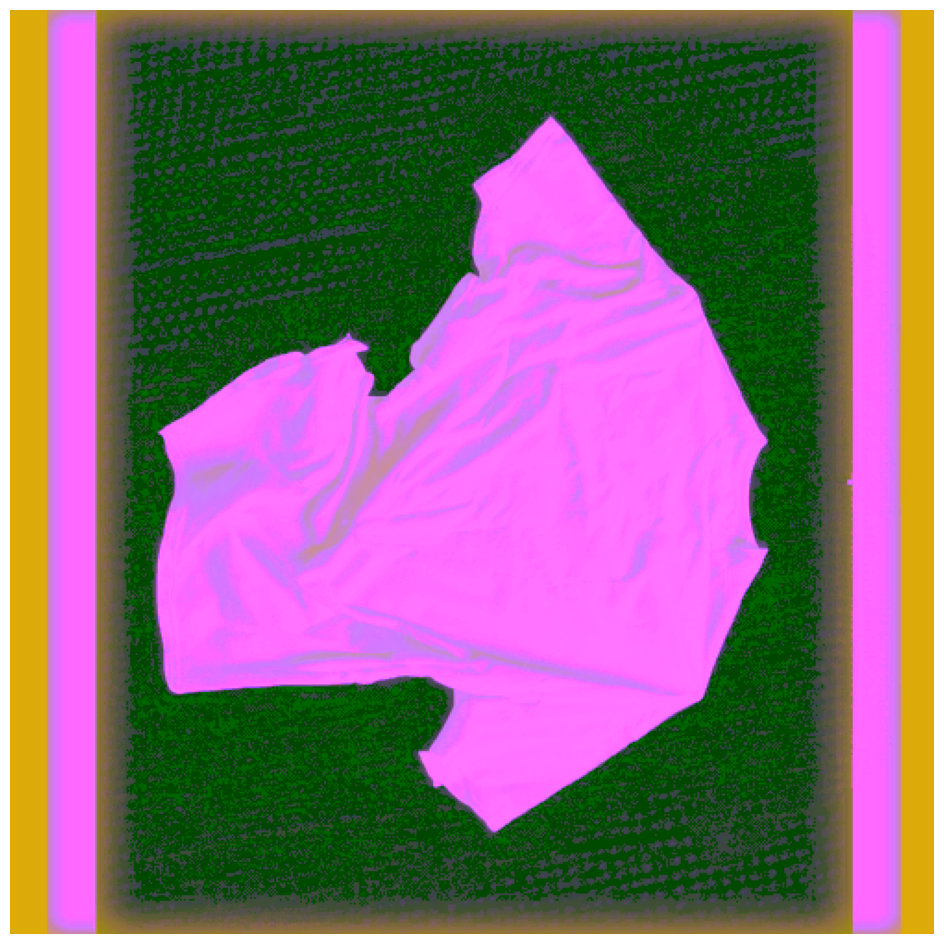

In [24]:
import os
import numpy as np
import cv2
from PIL import Image
import torch
import matplotlib.pyplot as plt
from transformers import YolosFeatureExtractor, YolosForObjectDetection

# Assuming you have these functions available
# from your_module import get_training_data_path, remove_shadow_rgb

# Load the pre-trained model and feature extractor
model_name = "hustvl/yolos-tiny"
feature_extractor = YolosFeatureExtractor.from_pretrained(model_name)
model = YolosForObjectDetection.from_pretrained(model_name)

# Load and preprocess the image
relative_path = get_training_data_path('production', 'tshirt')
fullpath = os.path.join(relative_path, '20240526_154948.png')
image = Image.open(fullpath)
image = image.rotate(-90)

# Convert to numpy array and process image for shadow removal
n_image = np.array(image)
image_ycrcb = cv2.cvtColor(n_image, cv2.COLOR_BGR2YCrCb)
processed_image = remove_shadow_rgb(image_ycrcb)  # Assuming remove_shadow_rgb can handle YCrCb images

# Convert back to PIL image for feature extraction
processed_pil_image = Image.fromarray(cv2.cvtColor(processed_image, cv2.COLOR_YCrCb2RGB))

# Prepare the image
inputs = feature_extractor(images=processed_pil_image, return_tensors="pt")

# Perform object detection
outputs = model(**inputs)

# Extract raw bounding boxes and scores
logits = outputs.logits[0]
bboxes = outputs.pred_boxes[0]
print(bboxes)
# Define the minimum area threshold
min_area_threshold = 1000  # Adjust this value based on your needs

plt.figure(figsize=(12, 12))
plt.imshow(processed_pil_image)
ax = plt.gca()

# Define the confidence threshold
confidence_threshold = 0.5

# Iterate over each bounding box and score
for logit, box in zip(logits, bboxes):
    score = torch.softmax(logit, dim=-1)[..., :-1].max().item()  # Get the highest score ignoring the background class
    if score > confidence_threshold:
        box = box.tolist()
        box_area = (box[2] - box[0]) * (box[3] - box[1])  # Calculate the area of the box
        if box_area >= min_area_threshold:  # Only draw boxes that exceed the area threshold
            rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                 fill=False, color="red", linewidth=2)
            ax.add_patch(rect)
            ax.text(box[0], box[1], f"{score:.2f}", color="white",
                    bbox=dict(facecolor='red', alpha=0.5))

plt.axis("off")
plt.show()
